# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [46]:
!pip uninstall umap

^C


In [1]:
!pip install shap

!pip install umap-learn
!pip install lightgbm

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/9c/c6/2190e240140f582007b36b256e7b015572c5644055e6e1f80d917c74a9ff/shap-0.43.0-cp310-cp310-win_amd64.whl.metadata
   --------------------------------------- 447.3/447.3 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3572 sha256=4a276598a85edda365dd52e271c0b654d819586274a987e8790fb47789ef79a8
  Stored in directory: c:\users\lrktl\appdata\local\pip\cache\wheels\15\f1\28\53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 1.3/1.3 MB 21.0 MB/s eta 0:00:00


In [47]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import umap_ as UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [23]:
ds_train = pd.read_csv("procesado.csv")


In [24]:
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "continua" else 1)
ds_train["clase_ternaria"]

0          continua
1          continua
2          continua
3          continua
4          continua
             ...   
4562805    continua
4562806    continua
4562807    continua
4562808    continua
4562809      baja+5
Name: clase_ternaria, Length: 4562810, dtype: object

In [25]:
ds_train = ds_train.drop("clase01",axis=1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [26]:
ds_bajas = ds_train.query("clase_ternaria != 'continua'")
ds_train = ds_train.drop("clase_ternaria", axis=1)
ds_bajas = ds_bajas.drop("clase_ternaria", axis=1)


In [196]:
ds_train.shape

(4562810, 286)

In [194]:
ds_bajas.shape

(91154, 286)

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [27]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.217114208391402,
    "num_leaves" : 269,
    "num_iterations" : 1531,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 6682,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Found `num_iterations` in params. Will use it instead of argument


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [28]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
80,cliente_edad,10953
0,numero_de_cliente,10201
2,cliente_antiguedad,7270
154,Master_fechaalta,6698
166,Visa_fechaalta,6171
...,...,...
38,ccomisiones_mantenimiento_slope_6,0
49,cplazo_fijo_slope_4,0
178,Visa_mconsumototal_ranknorm,0
107,cpayroll2_trx,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [29]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [207]:
import pickle
#Guardo en pickle el modelo
#pickle.dump(explainer, open('explainer.pk1','wb'))
#pickle.dump(gbm, open('gbm','wb'))

#Cargo el modelo
#explainer = pickle.load(open('explainer','rb'))
#gbm = pickle.load(open('gbm','rb'))

En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [37]:
print()
cliente_idx = 7 # el 
test = ds_bajas.iloc[7]

In [32]:
shap_bajas.iloc[7]

numero_de_cliente                     0.035134
foto_mes                             -1.085747
cliente_antiguedad                   -0.146068
Master_Fvencimiento                   0.027298
Visa_Fvencimiento                    -0.093584
                                        ...   
avg_6_mcomisiones_otras_ranknorm     -0.085383
avg_4_mcomisiones_otras_ranknorm     -0.082886
mcomisiones_otras_slope_6_ranknorm    0.000000
mcomisiones_otras_slope_4_ranknorm    0.000000
mcaja_ahorro_ranknorm                -0.667517
Name: 7, Length: 286, dtype: float64

In [38]:
pd.concat([ds_bajas.iloc[7], shap_bajas.iloc[7]], axis=1)

,597,7
numero_de_cliente,1.079648e+08,0.035134
foto_mes,2.019080e+05,-1.085747
cliente_antiguedad,1.020000e+02,-0.146068
Master_Fvencimiento,-1.673000e+03,0.027298
Visa_Fvencimiento,-2.038000e+03,-0.093584
...,...,...
avg_6_mcomisiones_otras_ranknorm,4.024430e-01,-0.085383
avg_4_mcomisiones_otras_ranknorm,4.267810e-01,-0.082886
mcomisiones_otras_slope_6_ranknorm,5.481300e-02,0.000000
mcomisiones_otras_slope_4_ranknorm,1.404800e-02,0.000000


Y consolidamos sus importancias

In [39]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

foto_mes                                  1.223161
cpayroll_trx                              0.700856
mprestamos_hipotecarios_ranknorm          0.653056
ctrx_quarter                              0.626420
mpayroll_ranknorm                         0.422209
                                            ...   
mprestamos_personales_slope_4_ranknorm    0.000000
mcuentas_saldo_slope_6_ranknorm           0.000000
mcuenta_corriente_slope_4_ranknorm        0.000000
mcuenta_corriente_slope_6_ranknorm        0.000000
ccomisiones_mantenimiento_slope_6         0.000000
Length: 286, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

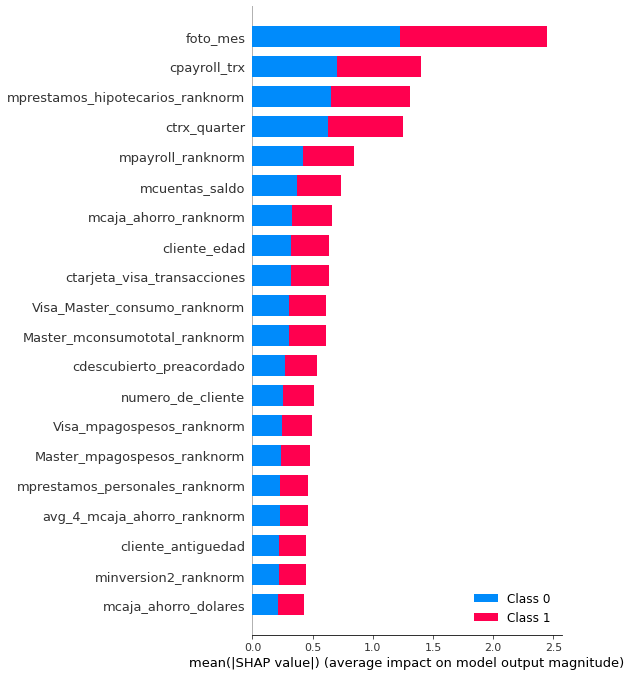

In [40]:
shap.summary_plot(shap_values, ds_bajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

¿Se podrá hacer una clusterización sobre los valores de shap?

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

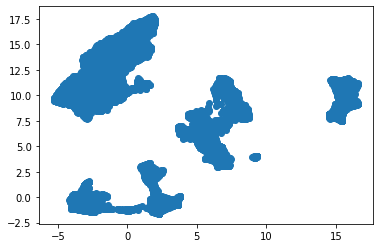

In [50]:
embedding_2d = UMAP.UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

(array([7.0000e+00, 2.4000e+01, 6.9000e+01, 1.1500e+02, 2.1600e+02,
        3.8100e+02, 8.6100e+02, 2.5580e+03, 1.0725e+04, 7.6198e+04]),
 array([0.01591871, 0.11432648, 0.21273425, 0.31114202, 0.40954979,
        0.50795757, 0.60636534, 0.70477311, 0.80318088, 0.90158865,
        0.99999643]),
 <BarContainer object of 10 artists>)

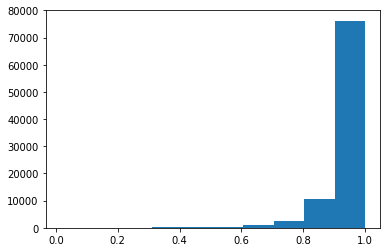

In [51]:
p_bajas = gbm.predict(ds_bajas)
plt.hist(p_bajas)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

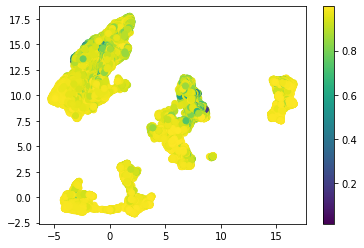

In [100]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


In [97]:
test = (y.labels_).tolist()
labels_umap = list(set(test))
labels_umap

[0, 1, 2, 3, 4]

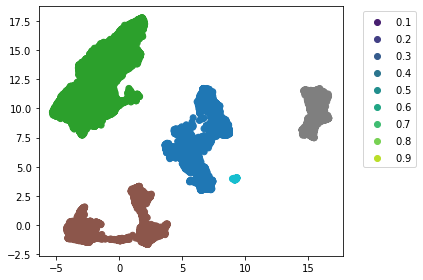

In [133]:

hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='tab10')
plt.legend(*sc.legend_elements(),bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

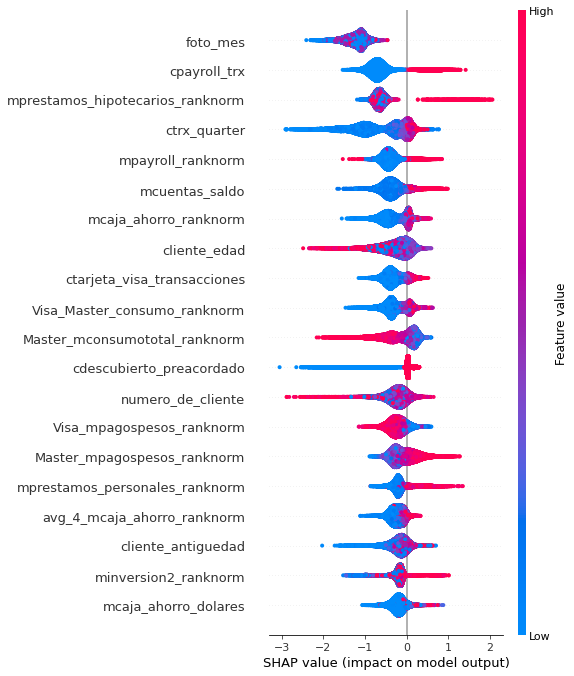

In [163]:
shap.summary_plot(shap_values[0], ds_bajas)

In [221]:
ds_train["ctrx_quarter"].mean()

111.15730394208832

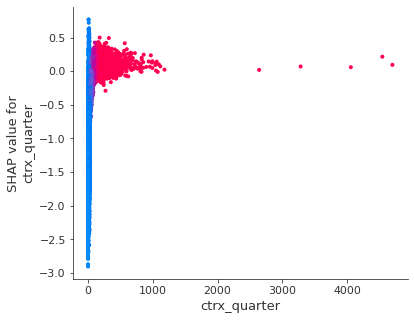

In [162]:
shap.dependence_plot("ctrx_quarter", shap_values[0], ds_bajas,interaction_index="ctrx_quarter")

In [142]:
for i in labels_umap:
    print(f"label {i} shape: ",shap_bajas[y.labels_ == i].shape)

label 0 shape:  (16942, 286)
label 1 shape:  (55508, 286)
label 2 shape:  (12479, 286)
label 3 shape:  (5996, 286)
label 4 shape:  (229, 286)


In [165]:
shap_0 = shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)
pd.set_option('display.max_rows', None)
shap_0.shape

(286,)

In [177]:
shap_values

[array([[-0.22191488, -1.17682184, -0.28781427, ...,  0.        ,
          0.        ,  0.03530299],
        [-0.06715083, -1.39096027, -0.20711408, ...,  0.        ,
          0.        , -0.92435115],
        [-0.08306739, -1.6263159 , -0.06836418, ...,  0.        ,
          0.        , -0.90718719],
        ...,
        [-0.03977026, -1.15648131, -0.50923223, ...,  0.        ,
          0.        , -0.39968103],
        [-0.14502702, -1.32144456, -0.08423971, ...,  0.        ,
          0.        ,  0.06587124],
        [-0.06761546, -1.1242357 ,  0.100891  , ...,  0.        ,
          0.        , -0.01822164]]),
 array([[ 0.22191488,  1.17682184,  0.28781427, ...,  0.        ,
          0.        , -0.03530299],
        [ 0.06715083,  1.39096027,  0.20711408, ...,  0.        ,
          0.        ,  0.92435115],
        [ 0.08306739,  1.6263159 ,  0.06836418, ...,  0.        ,
          0.        ,  0.90718719],
        ...,
        [ 0.03977026,  1.15648131,  0.50923223, ...,  

In [175]:
shap_bajas.head(10)

,numero_de_cliente,foto_mes,cliente_antiguedad,Master_Fvencimiento,Visa_Fvencimiento,tc_fvencimiento_mayor,tc_fvencimiento_menor,Visa_Master_ctarjetas,ctrx_quarter,lag_1_ctrx_quarter,...,lag_1_mcomisiones_otras_ranknorm,lag_2_mcomisiones_otras_ranknorm,lag_3_mcomisiones_otras_ranknorm,lag_4_mcomisiones_otras_ranknorm,delta_1_mcomisiones_otras_ranknorm,avg_6_mcomisiones_otras_ranknorm,avg_4_mcomisiones_otras_ranknorm,mcomisiones_otras_slope_6_ranknorm,mcomisiones_otras_slope_4_ranknorm,mcaja_ahorro_ranknorm
0,-0.221915,-1.176822,-0.287814,-0.047846,-0.170364,-0.054030,0.133126,-0.072131,-0.031113,-0.286398,...,-0.058860,-0.015911,0.046187,0.005293,0.024790,-0.186768,-0.028432,0.0,0.0,0.035303
1,-0.067151,-1.390960,-0.207114,-0.085914,-0.031806,-0.140902,0.105485,0.023423,0.010097,-0.180019,...,-0.072383,-0.071535,-0.062446,-0.031780,-0.028803,-0.079276,-0.090989,0.0,0.0,-0.924351
2,-0.083067,-1.626316,-0.068364,-0.117889,-0.003956,-0.103774,0.099070,0.020606,-0.351161,-0.086941,...,-0.034640,-0.026283,-0.038312,-0.024017,-0.124840,-0.111476,-0.075743,0.0,0.0,-0.907187
3,-0.059002,-1.637718,-0.049441,-0.092410,0.014000,-0.040198,0.093115,-0.073416,-0.245510,-0.127742,...,-0.045637,0.045685,-0.050831,-0.085809,-0.055480,-0.084754,0.039818,0.0,0.0,-0.894889
4,0.053822,-1.215914,-0.193274,-0.022988,-0.006071,-0.067217,0.060585,0.006900,0.144725,0.028512,...,-0.024557,-0.006943,-0.017205,-0.090340,-0.177632,-0.177179,-0.050999,0.0,0.0,-0.667240
5,0.141738,-1.049823,-0.413883,-0.035293,-0.129358,-0.290137,-0.020032,0.011965,0.142761,0.087267,...,-0.037787,-0.083943,-0.030788,-0.158701,-0.104410,-0.156901,-0.144625,0.0,0.0,-0.399481
6,0.067719,-1.225428,-0.196330,0.096386,0.150591,-0.014038,-0.063744,0.016367,0.156179,0.041609,...,-0.073457,0.071663,0.114066,-0.032785,-0.206819,-0.026210,-0.125818,0.0,0.0,-0.836555
7,0.035134,-1.085747,-0.146068,0.027298,-0.093584,-0.003755,-0.069795,0.003659,-0.050507,0.079307,...,-0.075115,-0.064875,0.023879,-0.070818,-0.085204,-0.085383,-0.082886,0.0,0.0,-0.667517
8,0.107134,-1.152808,-0.184375,0.028961,-0.027476,0.175679,0.028203,-0.001496,-0.007920,0.046047,...,0.024749,-0.001624,-0.077488,-0.003417,-0.105276,-0.060216,0.021763,0.0,0.0,-0.777668
9,0.124119,-1.886228,-0.174263,0.039269,0.068905,0.074119,-0.021826,-0.255666,-0.642323,0.096698,...,-0.195193,0.040999,-0.016249,-0.087068,-0.034235,-0.005625,0.006869,0.0,0.0,-0.610566


In [178]:
shap_bajas[y.labels_ == 4].head(5)

,numero_de_cliente,foto_mes,cliente_antiguedad,Master_Fvencimiento,Visa_Fvencimiento,tc_fvencimiento_mayor,tc_fvencimiento_menor,Visa_Master_ctarjetas,ctrx_quarter,lag_1_ctrx_quarter,...,lag_1_mcomisiones_otras_ranknorm,lag_2_mcomisiones_otras_ranknorm,lag_3_mcomisiones_otras_ranknorm,lag_4_mcomisiones_otras_ranknorm,delta_1_mcomisiones_otras_ranknorm,avg_6_mcomisiones_otras_ranknorm,avg_4_mcomisiones_otras_ranknorm,mcomisiones_otras_slope_6_ranknorm,mcomisiones_otras_slope_4_ranknorm,mcaja_ahorro_ranknorm
158,-0.061135,-1.470629,-0.204384,-0.127329,0.019592,-0.108598,-0.107112,-0.556779,-0.960732,-0.189383,...,-0.033882,-0.084385,-0.059805,-0.103893,-0.017947,-0.409107,-0.049234,0.0,0.0,-0.096247
1148,-0.048452,-1.380564,-0.212916,-0.042728,-0.113277,-0.142235,-0.158042,-0.333368,-0.840839,-0.089328,...,0.019342,0.005843,0.042679,-0.051438,-0.175755,-0.257598,-0.210002,0.0,0.0,-0.053843
1604,-0.068211,-1.356714,-0.148881,-0.278235,-0.088220,0.003517,-0.179827,-0.028739,-0.372842,-0.121810,...,-0.004711,0.004220,-0.109474,-0.104704,-0.069545,-0.078727,-0.055926,0.0,0.0,0.047255
1621,0.069384,-1.533487,-0.085327,-0.022641,0.161755,0.257409,-0.536013,-0.384456,-0.837647,-0.199899,...,-0.089405,-0.007969,0.018207,-0.087421,-0.061200,-0.194772,0.022200,0.0,0.0,-0.311025
3321,-0.247774,-1.642493,-0.030634,-0.227481,-0.211850,-0.134568,0.110600,-0.075764,-1.245351,-0.268424,...,-0.012898,-0.024486,-0.004317,-0.075692,-0.053405,-0.023001,-0.024824,0.0,0.0,-0.590896


In [222]:
lables = ["shape_0","shape_1","shape_2","shape_3","shape_4"]

In [225]:
shape_4 = ds_bajas[y.labels_==4]
shap_values_4 = explainer.shap_values(shape_4)
shap.summary_plot(shap_values_4, shape_4)

In [226]:
shap_values_4 = explainer.shap_values(shape_4)
#shap_bajas = pd.DataFrame(shap_values[0], columns = test_shape_chico.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


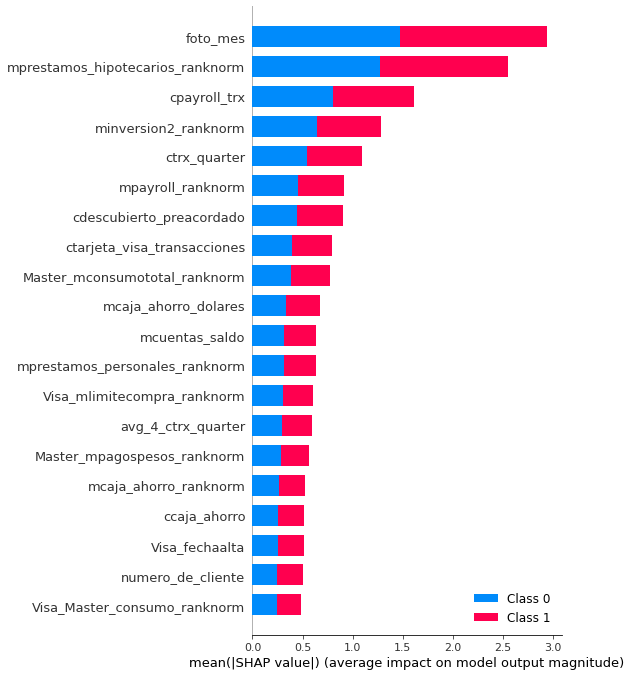

In [227]:
shap.summary_plot(shap_values_4, shape_4)

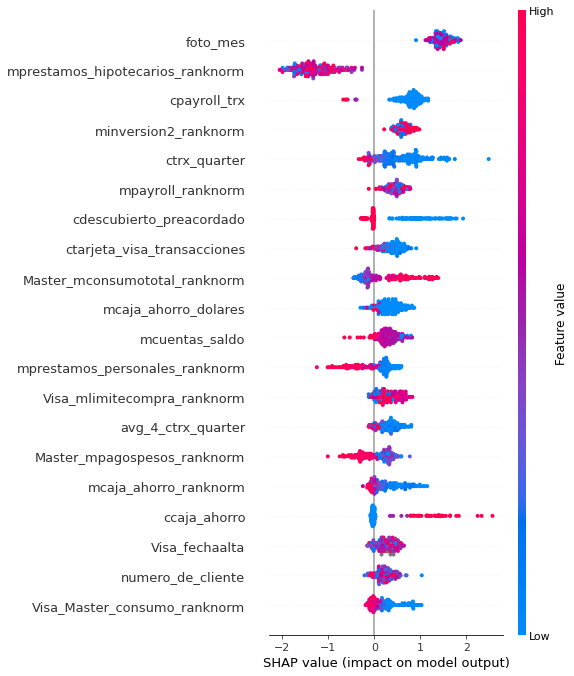

In [232]:
shap.summary_plot(shap_values_4[1], shape_4)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


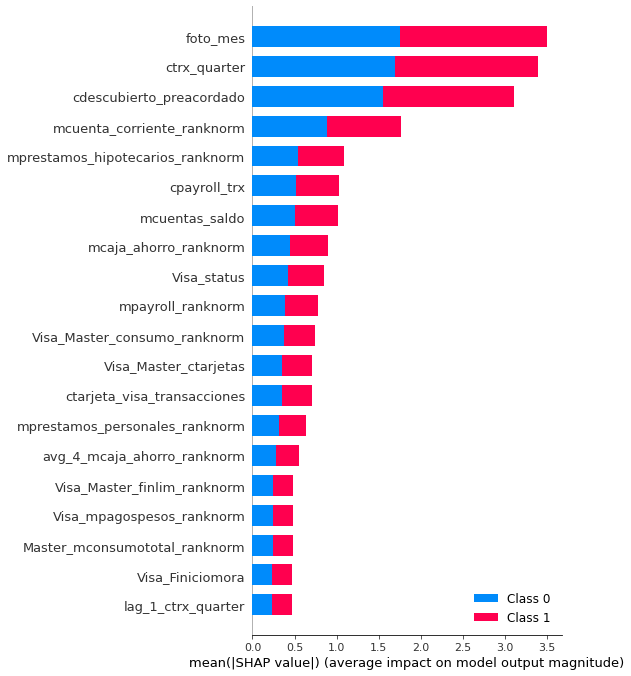

In [229]:
shape_3 = ds_bajas[y.labels_==3]
shap_values_3 = explainer.shap_values(shape_3)
shap.summary_plot(shap_values_3, shape_3)

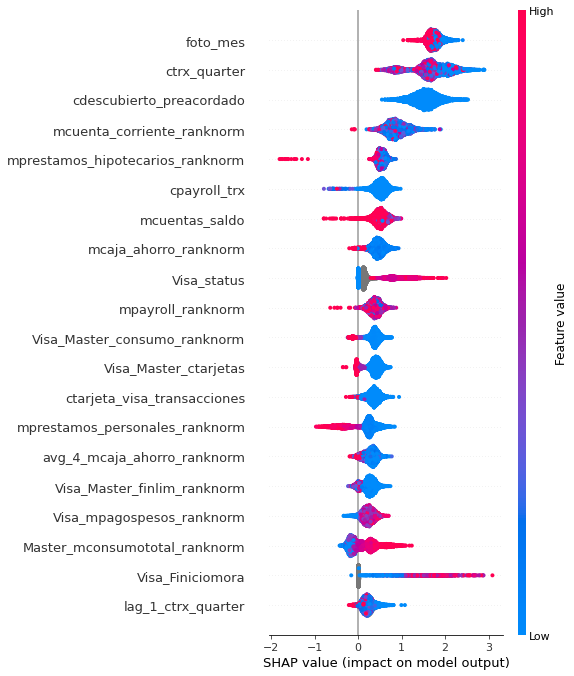

In [231]:
shap.summary_plot(shap_values_3[1], shape_3)

In [243]:
shape_3.ctrx_quarter.mean()

6.486991327551701

In [244]:
ds_bajas.ctrx_quarter.mean()

43.67685455383198

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


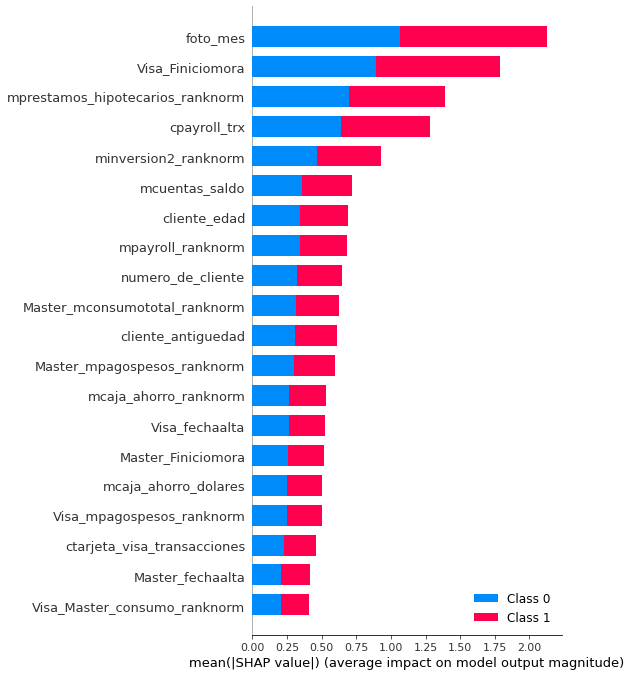

In [233]:
shape_2 = ds_bajas[y.labels_==2]
shap_values_2 = explainer.shap_values(shape_2)
shap.summary_plot(shap_values_2, shape_2)

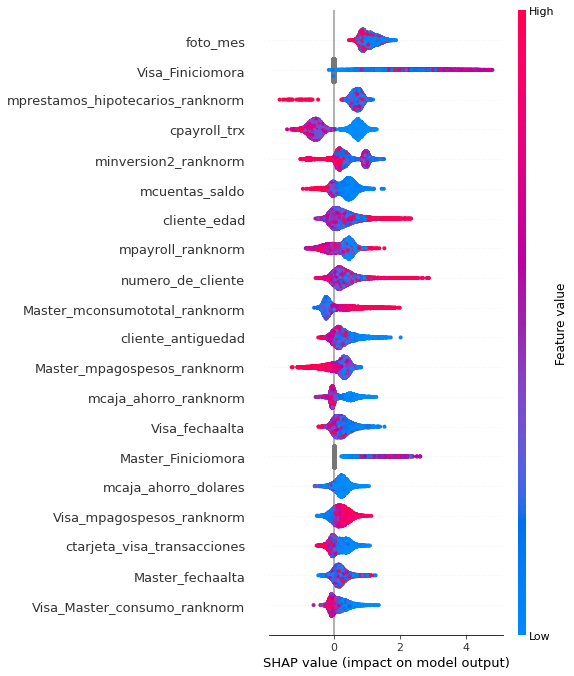

In [234]:
shap.summary_plot(shap_values_2[1], shape_2)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


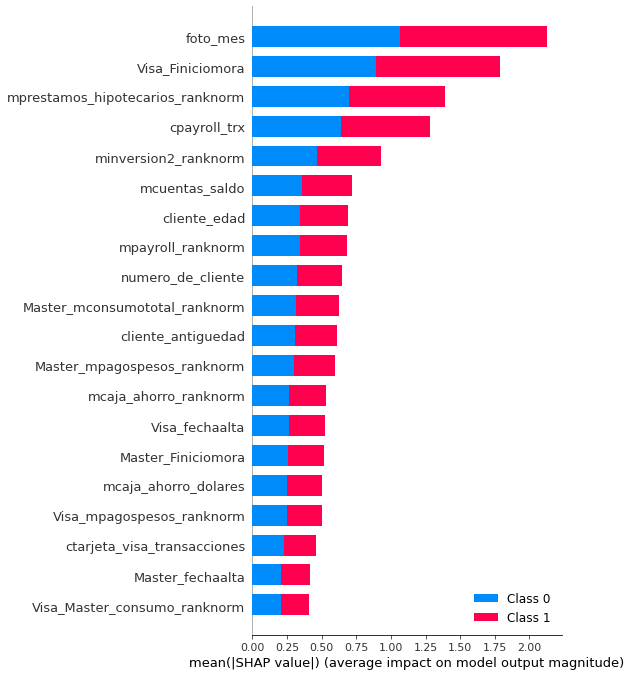

In [235]:
shape_1 = ds_bajas[y.labels_==2]
shap_values_1 = explainer.shap_values(shape_1)
shap.summary_plot(shap_values_1, shape_1)

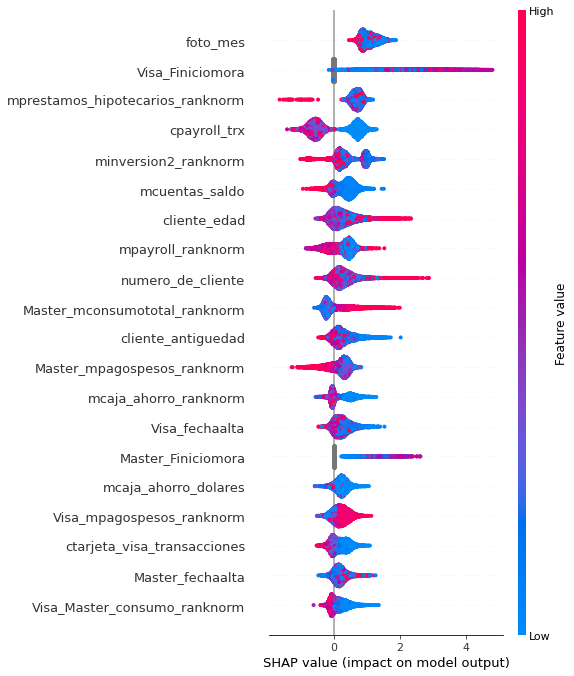

In [236]:
shap.summary_plot(shap_values_1[1], shape_1)

In [ ]:
shape_0 = ds_bajas[y.labels_==2]
shap_values_0 = explainer.shap_values(shape_0)
shap.summary_plot(shap_values_0, shape_0)

In [ ]:
shap.summary_plot(shap_values_0[1], shape_0)

In [114]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

cdescubierto_preacordado                         0.047298
Visa_Master_ctarjetas                            0.031096
delta_1_ccomisiones_mantenimiento                0.026940
Visa_Master_saldototal_ranknorm                  0.005520
Visa_Finiciomora                                 0.004268
Visa_status                                      0.004101
ctarjeta_visa_debitos_automaticos                0.003695
Master_Finiciomora                               0.002611
catm_trx_other                                   0.001586
cforex_buy                                       0.001272
tcuentas                                         0.001109
cforex                                           0.000980
lag_1_cplazo_fijo                                0.000477
Master_delinquency                               0.000329
Visa_delinquency                                 0.000251
Master_madelantopesos                            0.000190
cprestamos_hipotecarios                          0.000109
cplazo_fijo_sl

In [119]:
shap_bajas[y.labels_ == 4].mean().sort_values(ascending=False)

mprestamos_hipotecarios_ranknorm                 1.276761
delta_1_ccomisiones_mantenimiento                0.036344
cprestamos_prendarios                            0.031706
ctarjeta_visa_debitos_automaticos                0.022673
lag_3_cpayroll_trx                               0.005479
Visa_Master_saldopesos_slope_6                   0.004351
cforex_buy                                       0.003158
Visa_Finiciomora                                 0.003069
lag_4_cpayroll_trx                               0.002960
Master_mconsumosdolares                          0.002058
lag_2_cpayroll_trx                               0.001985
lag_2_Visa_Master_saldopesos                     0.001827
Master_delinquency                               0.001560
catm_trx_other                                   0.001385
lag_3_cplazo_fijo                                0.000525
cforex_sell                                      0.000483
lag_2_cplazo_fijo                                0.000138
ccheques_depos

In [268]:
variable = "mprestamos_hipotecarios_ranknorm"

print(ds_bajas[variable].mean())
ds_bajas.loc[y.labels_ == 4][variable].mean()

0.4950171763499133


0.9897219082969432

In [257]:
ds_bajas.loc[y.labels_ == 4]["cpayroll_trx"].mean()

0.048034934497816595

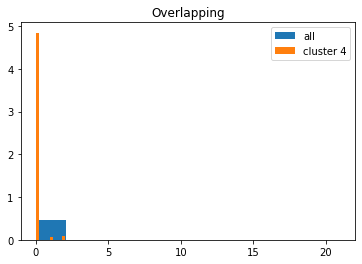

In [255]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True)
plt.hist(ds_bajas.loc[y.labels_ == 4]["cpayroll_trx"], label='cluster 4', density=True)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

## Random Forest distance

Armamos un conjunto de datos

In [ ]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [ ]:
XRF = Xtrain.iloc[rf_index]
yRF = ytrain.iloc[rf_index]

In [ ]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Umap de rf

using precomputed metric; inverse_transform will be unavailable


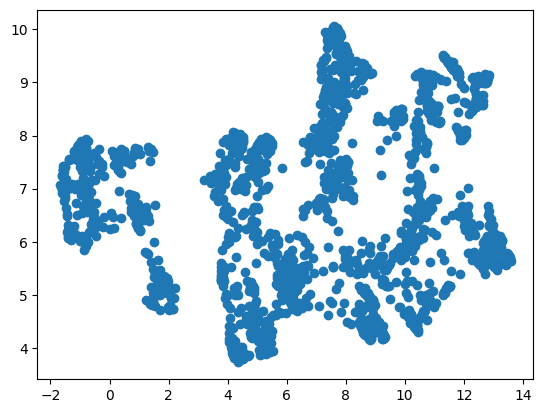

In [ ]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1])

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])